In [1008]:

# data
import pandas as pd
import numpy as np
import nltk

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import TruncatedSVD
# Pipeline and model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
# Score of models
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier

In [1009]:
url = "SMSSpamCollection.txt"
df = pd.read_csv(url, sep='\t', header=None )
df.rename(columns={0:'type',1:'mail'}, inplace=True)
df


,type,mail
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [1010]:
df['minuscule']=df['mail'].str.lower()
df

,type,mail,minuscule
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ..."
1,ham,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro..."
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?,will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s...","pity, * was in mood for that. so...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...


In [1011]:
# tokenizer avec RE (regular expressions)
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')

# tokenizer = RegexpTokenizer(r"[a-zA-Z]\w+\'?\w*")
tokenizer = RegexpTokenizer(r"\b\w+\b|\d{2} \d{2} \d{2} \d{2} \d{2}")

df['token'] = df['minuscule'].apply(lambda x: tokenizer.tokenize(x))
df


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MOHAM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,type,mail,minuscule,token
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...","[go, until, jurong, point, crazy, available, o..."
1,ham,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...","[nah, i, don, t, think, he, goes, to, usf, he,..."
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,..."
5568,ham,Will ü b going to esplanade fr home?,will ü b going to esplanade fr home?,"[will, ü, b, going, to, esplanade, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...","pity, * was in mood for that. so...any other s...","[pity, was, in, mood, for, that, so, any, othe..."
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...,"[the, guy, did, some, bitching, but, i, acted,..."


In [1012]:

from nltk.corpus import stopwords
nltk.download('stopwords')
# Supprimer les stop words
stop = stopwords.words('english')

df['without_stopwords']=df['token'].apply(lambda x: [word for word in x if word not in stop])
df


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MOHAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,type,mail,minuscule,token,without_stopwords
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...","[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...","[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]"
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, 750, poun..."
5568,ham,Will ü b going to esplanade fr home?,will ü b going to esplanade fr home?,"[will, ü, b, going, to, esplanade, fr, home]","[ü, b, going, esplanade, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...","pity, * was in mood for that. so...any other s...","[pity, was, in, mood, for, that, so, any, othe...","[pity, mood, suggestions]"
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, interested, buyin..."


In [1013]:

from nltk.stem import PorterStemmer

# stemmer notre list

stemmer = PorterStemmer()
df['PorterStemmer'] = df['without_stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])
df

,type,mail,minuscule,token,without_stopwords,PorterStemmer
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...","[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,ham,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...","[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, goe, usf, live, around, though]"
...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, 750, poun...","[2nd, time, tri, 2, contact, u, u, 750, pound,..."
5568,ham,Will ü b going to esplanade fr home?,will ü b going to esplanade fr home?,"[will, ü, b, going, to, esplanade, fr, home]","[ü, b, going, esplanade, fr, home]","[ü, b, go, esplanad, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...","pity, * was in mood for that. so...any other s...","[pity, was, in, mood, for, that, so, any, othe...","[pity, mood, suggestions]","[piti, mood, suggest]"
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, interested, buyin...","[guy, bitch, act, like, interest, buy, someth,..."


In [1014]:

df['clean'] = df['without_stopwords'].apply(lambda x: " ".join(x))
df

,type,mail,minuscule,token,without_stopwords,PorterStemmer,clean
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...","[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]",ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin...",free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]",u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...","[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, goe, usf, live, around, though]",nah think goes usf lives around though
...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, 750, poun...","[2nd, time, tri, 2, contact, u, u, 750, pound,...",2nd time tried 2 contact u u 750 pound prize 2...
5568,ham,Will ü b going to esplanade fr home?,will ü b going to esplanade fr home?,"[will, ü, b, going, to, esplanade, fr, home]","[ü, b, going, esplanade, fr, home]","[ü, b, go, esplanad, fr, home]",ü b going esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...","pity, * was in mood for that. so...any other s...","[pity, was, in, mood, for, that, so, any, othe...","[pity, mood, suggestions]","[piti, mood, suggest]",pity mood suggestions
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, interested, buyin...","[guy, bitch, act, like, interest, buy, someth,...",guy bitching acted like interested buying some...


In [1015]:
df['len']=df['mail'].str.len()
# df['nombre_mots']=df['mail'].str.split().str.len()
df['nombre_mots']=df['token'].str.len()

import re
pattern = r"http\S+"
df['http_compt']=df['mail'].apply(lambda x: len(re.findall(pattern, x)))

pattern = r"([+-]?(?=\.\d|\d)(?:\d+)?(?:\.?\d*))(?:[Ee]([+-]?\d+))?"
df['phone_compt']=df['mail'].apply(lambda x: len(re.findall(pattern, x)))

pattern = r"[-A-Za-z0-9!#$%&'*+/=?^_`{|}~]+(?:\.[-A-Za-z0-9!#$%&'*+/=?^_`{|}~]+)*@(?:[A-Za-z0-9](?:[-A-Za-z0-9]*[A-Za-z0-9])?\.)+[A-Za-z0-9](?:[-A-Za-z0-9]*[A-Za-z0-9])?"
df['mail_compt']=df['mail'].apply(lambda x: len(re.findall(pattern, x)))

df[(df['phone_compt']>0) & (df['type']=='spam')]

,type,mail,minuscule,token,without_stopwords,PorterStemmer,clean,len,nombre_mots,http_compt,phone_compt,mail_compt
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin...",free entry 2 wkly comp win fa cup final tkts 2...,155,33,0,6,0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darling it's been 3 week's n...,"[freemsg, hey, there, darling, it, s, been, 3,...","[freemsg, hey, darling, 3, week, word, back, l...","[freemsg, hey, darl, 3, week, word, back, like...",freemsg hey darling 3 week word back like fun ...,147,36,0,2,0
8,spam,WINNER!! As a valued network customer you have...,winner!! as a valued network customer you have...,"[winner, as, a, valued, network, customer, you...","[winner, valued, network, customer, selected, ...","[winner, valu, network, custom, select, receiv...",winner valued network customer selected receiv...,157,26,0,4,0
9,spam,Had your mobile 11 months or more? U R entitle...,had your mobile 11 months or more? u r entitle...,"[had, your, mobile, 11, months, or, more, u, r...","[mobile, 11, months, u, r, entitled, update, l...","[mobil, 11, month, u, r, entitl, updat, latest...",mobile 11 months u r entitled update latest co...,154,29,0,2,0
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...","six chances to win cash! from 100 to 20,000 po...","[six, chances, to, win, cash, from, 100, to, 2...","[six, chances, win, cash, 100, 20, 000, pounds...","[six, chanc, win, cash, 100, 20, 000, pound, t...",six chances win cash 100 20 000 pounds txt csh...,136,28,0,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,want explicit sex in 30 secs? ring 02073162414...,"[want, explicit, sex, in, 30, secs, ring, 0207...","[want, explicit, sex, 30, secs, ring, 02073162...","[want, explicit, sex, 30, sec, ring, 020731624...",want explicit sex 30 secs ring 02073162414 cos...,90,17,0,6,0
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,asked 3mobile if 0870 chatlines inclu in free ...,"[asked, 3mobile, if, 0870, chatlines, inclu, i...","[asked, 3mobile, 0870, chatlines, inclu, free,...","[ask, 3mobil, 0870, chatlin, inclu, free, min,...",asked 3mobile 0870 chatlines inclu free mins i...,158,33,0,7,0
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,had your contract mobile 11 mnths? latest moto...,"[had, your, contract, mobile, 11, mnths, lates...","[contract, mobile, 11, mnths, latest, motorola...","[contract, mobil, 11, mnth, latest, motorola, ...",contract mobile 11 mnths latest motorola nokia...,160,27,0,1,0
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,reminder from o2: to get 2.50 pounds free call...,"[reminder, from, o2, to, get, 2, 50, pounds, f...","[reminder, o2, get, 2, 50, pounds, free, call,...","[remind, o2, get, 2, 50, pound, free, call, cr...",reminder o2 get 2 50 pounds free call credit d...,147,29,0,3,0


In [1016]:
# Train test split

X = df.drop(['type'], axis=1)
y = df['type']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)



In [1017]:
# C'est juste un test
vectorizertest = TfidfVectorizer(decode_error='ignore', analyzer='char_wb', ngram_range=(2, 2))
matrix = vectorizertest.fit_transform(df['clean'])
matrix.shape


(5572, 1073)

In [1018]:
matrix.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.07280357, 0.        , 0.19583036, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [1019]:

# vectorizertest.get_feature_names_out() # C'est le dictionnaire

In [1020]:
column_num = X.select_dtypes(exclude=['object']).columns
column_num

Index(['len', 'nombre_mots', 'http_compt', 'phone_compt', 'mail_compt'], dtype='object')

In [1021]:
# Transformation of textual variables
transfo_text_TFid = Pipeline(steps=[
    ('Tfid', TfidfVectorizer(decode_error='ignore', analyzer='char_wb', ngram_range=(2, 2)))
    
])

transfo_text_CountVect = Pipeline(steps=[  
    ('boCountVectorizerw', CountVectorizer(decode_error='ignore', analyzer='char_wb',strip_accents='unicode', ngram_range=(2, 2)))
])


# Class ColumnTransformer : apply alls steps on the whole dataset
preparation = ColumnTransformer(
    transformers=[
        ('TFid&data', transfo_text_TFid , 'mail'), #TFIDF ne prend pas de listes comme arguments
        # ('CountVect&data', transfo_text_CountVect , 'mail'),
        
        # ('MinMaxScaler&data',MinMaxScaler(), column_num) #['http_compt', 'mail_compt']
        # ('data',StandardScaler(), column_num) #Les classifieurs NB ne prend pas de valeur négatif
        # ('data',RobustScaler(), column_num) #Les classifieurs NB ne prend pas de valeur négatif
    ])
preparation


ColumnTransformer(transformers=[('TFid&data',
                                 Pipeline(steps=[('Tfid',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  decode_error='ignore',
                                                                  ngram_range=(2,
                                                                               2)))]),
                                 'mail')])

In [1022]:
# Creation of model : a ready to use pipeline for ML process
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process.kernels import RBF

# classifier =ComplementNB()                                        #0.9838516746411483
# classifier = MultinomialNB()                                      #0.9856459330143541


# classifier =SVC(gamma='auto')                                     #0.9742822966507177
# classifier =SVC(gamma=2, C=1, random_state=42)                    #0.8941387559808612

# classifier =KNeighborsClassifier(7)                               #0.9527511961722488

classifier =LogisticRegression(C=1e2)                             # 0.9894497607655502

# classifier =RandomForestClassifier(max_depth=200, random_state=42)#0.9838516746411483
# classifier =DecisionTreeClassifier()                              #0.9700956937799043


In [1023]:
# Dimensionality reduction using truncated SVD 
svd = TruncatedSVD(n_components=700, n_iter=7, random_state=42)

In [1024]:
model_lm = Pipeline([
    ('vectorizer', preparation),
    # ('svd', svd), #Ça génère des valeurs négatives et les NB n'aime pas ça
    ('classifier', classifier)
])

In [1025]:

# Fit the model
model_lm.fit(X_train, y_train)

c:\Users\MOHAM\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 ColumnTransformer(transformers=[('TFid&data',
                                                  Pipeline(steps=[('Tfid',
                                                                   TfidfVectorizer(analyzer='char_wb',
                                                                                   decode_error='ignore',
                                                                                   ngram_range=(2,
                                                                                                2)))]),
                                                  'mail')])),
                ('classifier', LogisticRegression(C=100.0))])

In [1026]:
# Predict on test data

y_pred = model_lm.predict(X_test)
y_pred

array(['spam', 'ham', 'spam', ..., 'spam', 'ham', 'ham'], dtype=object)

In [1027]:
# Performance of the model
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9892344497607656


In [1028]:
from sklearn.metrics import classification_report, confusion_matrix
# Afficher le rapport de classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1448
        spam       0.99      0.93      0.96       224

    accuracy                           0.99      1672
   macro avg       0.99      0.96      0.98      1672
weighted avg       0.99      0.99      0.99      1672



In [1029]:

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Confusion matrix:
 [[1446    2]
 [  16  208]]


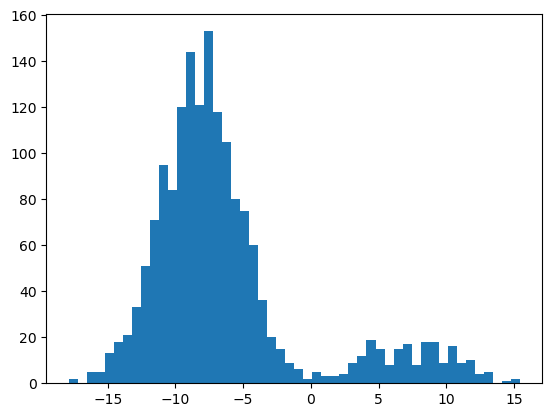

In [1030]:
import matplotlib.pyplot as plt
plt.hist(model_lm.decision_function(X_test), bins=50)
plt.show()

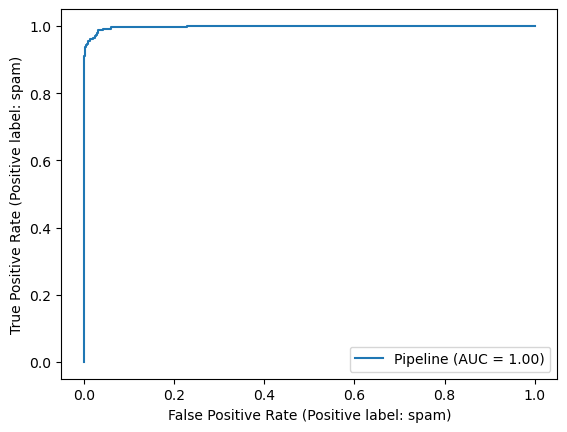

In [1031]:
from sklearn.metrics import RocCurveDisplay




svc_disp = RocCurveDisplay.from_estimator(model_lm, X_test, y_test)
